In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from isingCA_local_connectivity_xi import isingCA
import pygame
from tqdm import tqdm

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from itertools import product

# toggle the brush between two modes (shortcut B)
BRUSH_TOGGLE = False

def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
     # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    # doesn't do periodic boundaries
    # state[:, 1, xcl - r:xcl + r, ycl - r : ycl + r] -= (blur.cuda() + 1e-6) 
    
    range_x = range(xcl - r, xcl + r)
    range_y = range(ycl - r, ycl + r)
    coords = list(product(range_x, range_y))
    idx_i = [c[0] % RESX for c in coords]
    idx_j = [c[1] % RESY for c in coords]
    
    if BRUSH_TOGGLE:
        state[:, 1, idx_i, idx_j] -= (blur.reshape(-1).cuda() + 1e-6) # change temp
    else:
        state[:, 0, idx_i, idx_j] = torch.where(rm.reshape(-1).cuda() <= 1.,
                                                1.,
                                                state[:, 0, idx_i, idx_j]
                                               )
    
    state[0, 1] = torch.clip(state[0, 1], 1e-6)

    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    range_x = range(xcl - r, xcl + r)
    range_y = range(ycl - r, ycl + r)
    coords = list(product(range_x, range_y))
    idx_i = [c[0] % RESX for c in coords]
    idx_j = [c[1] % RESY for c in coords]
    if BRUSH_TOGGLE:
        state[:, 1, idx_i, idx_j] += blur.reshape(-1).cuda()
    else:
        state[:, 0, idx_i, idx_j] = torch.where(rm.reshape(-1).cuda() <= 1.,
                                                -1.,
                                                state[:, 0, idx_i, idx_j]
                                               )
    
    return state

def WHEEL_permute(cdim_order, direction, mod):
    cdim_order = np.mod(np.add(cdim_order, direction), mod)
    
    return cdim_order
    
def WHEEL_beta(beta, direction):
    
    return beta + direction * 0.01

def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

In [3]:
def print_something(something):
    fps = f'{something:.3f}'
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf

# Test

In [4]:
RADIUS=1
# BETA=1. / (RADIUS*RADIUS)
BETA=1.
RES=(320, 320)
ca=isingCA(RES, BETA=BETA, RADIUS=RADIUS).cuda()

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# resolution of grid
RESX=RES[0]
RESY=RES[1]
state = ca.initGrid((RESX, RESY))
# state[0, -1] = 0.1 * torch.ones_like(state[0, -1])
# brush properties
r = RESX//20
s = 0.1

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 3

RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, state.shape[1] + 1)
beta = BETA

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################


ticker = 0.
export_imgs = False
imgs = []

# stats to save
temps = []
mag = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y
                
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1] + 1)
                    
            if event.type == pygame.KEYDOWN and event.key == pygame.K_o:
                ca.rule.J_adapt = not ca.rule.J_adapt
        
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid((RESX, RESY))
            if event.type == pygame.KEYDOWN and event.key == pygame.K_b:
                BRUSH_TOGGLE = not BRUSH_TOGGLE
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_9:
                ca.rule.adapt_lr /= 2.
                print(f'lr: {ca.rule.adapt_lr :.4f}')
            if event.type == pygame.KEYDOWN and event.key == pygame.K_0:
                ca.rule.adapt_lr *= 2.
                print(f'lr: {ca.rule.adapt_lr :.4f}')

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
        
        
        if WHEEL_trigger:
#             ca.rule.beta = WHEEL_beta(ca.rule.beta, direction)
            cdim_order = WHEEL_permute(cdim_order, direction, mod=len(cdim_order))
            WHEEL_trigger = False
        if cdim_order[0] == len(cdim_order) - 1:
            nx = ca.rule.nearest_neighbours.reshape(1, (2 * RADIUS + 1) ** 2, RESX, RESY).sum(dim=1).cpu().numpy()[0]
            # nx = np.log1p(nx)
            nx = 0.88 * min_max(nx) * 255.
            nx = np.stack([234/255*nx, 170/255*nx, 31/255*nx]).transpose(1, 2, 0)
        elif cdim_order[0] == 1:
            nx = 0.5 * (state[0, cdim_order[0], :, :].cpu().numpy() + 1) * 230.
            nx = np.stack([0 *nx, 154/255*nx, 211/255*nx]).transpose(1, 2, 0)
            nx2 = 0.98 * (state[0, 0, :, :].cpu().numpy() + 1) * 20.
            nx2 = np.stack([208/255*nx2, 80/255*nx2, 250/255*nx2]).transpose(1, 2, 0)
            nx += nx2
        else:
            nx = 0.5 * (state[0, cdim_order[0], :, :].cpu().numpy() + 1) * 255.
            nx = np.stack([0 *nx, 154/255*nx, 211/255*nx]).transpose(1, 2, 0)

        if time_ticking:
            state = ca.forward(state)
            ticker += 1


        if export_imgs and time_ticking:
            imgs.append(nx)
            
        mat_draw = min_max(ca.rule.nearest_neighbours[0, :, RESX*RESY // 2 + RESY].reshape(2*RADIUS + 1,2*RADIUS + 1).detach()).cpu().numpy()
        connectivity_mat = pygame.transform.scale(pygame.surfarray.make_surface(mat_draw*255), (50, 50))
        
        pygame.surfarray.blit_array(screen, nx)   
        screen.blit(connectivity_mat, (RESX - 50,0))
        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        
        magnetization = state[0, 0].mean().cpu().numpy()
        connectivity = ca.rule.nearest_neighbours.sum(dim=1).mean().cpu().numpy()
        connectivity2 = ca.rule.nearest_neighbours.cpu()
        zero_mask = connectivity2.abs() > 1e-6
        connectivity2[~zero_mask] = torch.nan
        connectivity2 = torch.nanmean(connectivity2, dim=1).mean().numpy()

        upscaled_screen.blit(print_something(magnetization), (10,10))
        upscaled_screen.blit(print_something(connectivity), (10,20))
        upscaled_screen.blit(print_something(connectivity2), (35,20))
        pygame.display.flip()
        clock.tick(240)
        
pygame.quit()


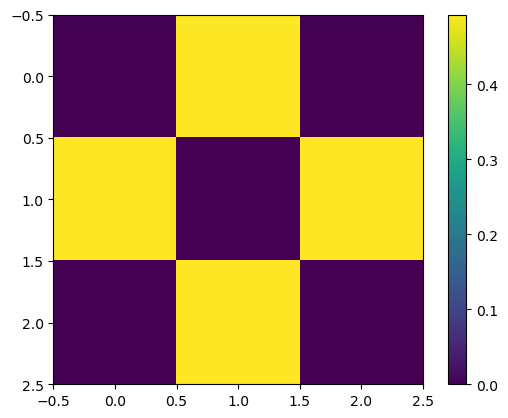

In [6]:
k = ca.rule.nearest_neighbours.cpu().mean(dim=-1).squeeze().numpy()
plt.imshow(k.reshape(2*[2*RADIUS+1])); plt.colorbar()

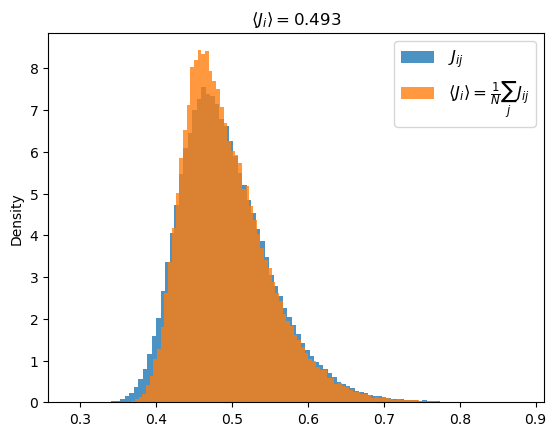

In [7]:
data = ca.rule.nearest_neighbours.cpu()
zero_mask = data.abs() > 1e-6
data = data[zero_mask].numpy().reshape(-1)
plt.hist(data, 100, alpha=0.8, density=True, label=r'$J_{ij}$'); #plt.yscale('log'); # plt.xscale('log')

data2 = ca.rule.nearest_neighbours.cpu()
zero_mask = data2.abs() > 1e-6
data2[~zero_mask] = torch.nan
data2 = torch.nanmean(data2, dim=1).numpy().reshape(-1)
plt.hist(data2, 100, alpha=0.8, density=True, label=r'$\langle J_i \rangle=\frac{1}{N} \sum_{j} J_{ij}$');

plt.legend(fontsize=12)
plt.ylabel('Density')

# title_str = fr'$\beta_c J_1 = 0.44; \beta_1 \langle J^{{t_f}}_i \rangle = {np.mean(data2):.3f}$'
title_str = fr'$\langle J_i \rangle = {np.mean(data2):.3f}$'
plt.title(title_str);

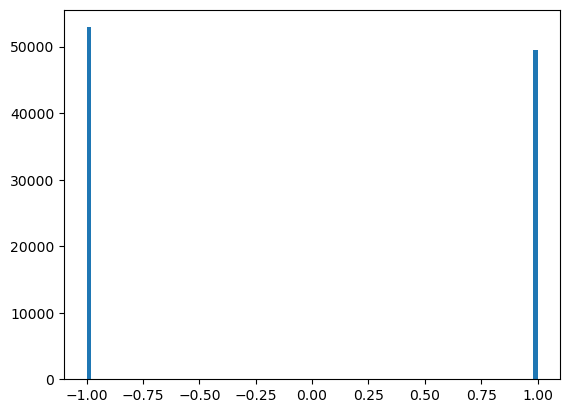

In [8]:
plt.hist(state[0, 0].reshape(-1).cpu().numpy(), 100); #plt.yscale('log');

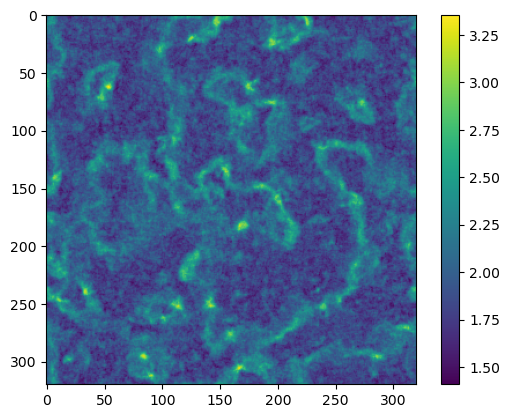

In [9]:
plot1 = ca.rule.nearest_neighbours.reshape(1, (2 * RADIUS + 1) ** 2, RESX, RESY).sum(dim=1).cpu().numpy()[0]
# vmax=np.median(plot1) + np.std(plot1)
plt.imshow(plot1.T); plt.colorbar()

In [10]:
import time
import cv2

# Set up video writer
fname = time.strftime("%Y%m%d-%H%M%S")
output_file = f'videos/CA-{fname}.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 450
frame_size = (RESY, RESX)
out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

# Iterate through list of arrays and write each frame to the video writer
for img in imgs:
    out.write(img.astype('uint8').transpose(1, 0, 2))

# Release the video writer
out.release()

## Test for criticality

In [11]:
from copy import deepcopy

def init_clone(ca):
    ca_clone = deepcopy(ca)
    ca_clone.rule.J_adapt = False
    return ca_clone

In [13]:
beta_scales = 10 ** np.linspace(-1, 0.6, 88)
eq_steps = 2048
timesteps = 10 * 2048

# stats to save
save_every = 10
all_obvs = []
Cs = []


for beta_s in tqdm(beta_scales):
    ca_clone = init_clone(ca)
    state = ca_clone.initGrid()
    beta = BETA * beta_s

    state[0, 0] = (torch.rand(1, 1, RES[0], RES[1]) > 0.5) * 2. - 1.
    state[0, -1] = beta * torch.ones_like(state[0, -1])

    # equilibrate for a bit
    for t in range(eq_steps):
        state = ca_clone.forward(state)

    all_obvs_t = []
    for t in range(timesteps):
        state, obvs = ca_clone.forward(state, make_obv=True)

        if t % save_every == 0:
            all_obvs_t.append(obvs.cpu().numpy())

    all_obvs_t = np.stack(all_obvs_t)

    e_t = all_obvs_t[:, 0]
    e2_t = all_obvs_t[:, 1]
    m_t = all_obvs_t[:, 2]
    m2_t = all_obvs_t[:, 3]


    E_t = np.mean(e_t)
    M_t = np.mean(m_t)
    C_t = RES[0] * (np.mean(e2_t) - np.mean(e_t) ** 2) * beta ** 2
    X_t = RES[0] * (np.mean(m2_t) - np.mean(m_t) ** 2) * beta

    all_obvs.append(np.stack([E_t, M_t, C_t, X_t]))

100%|██████████| 88/88 [20:39<00:00, 14.09s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


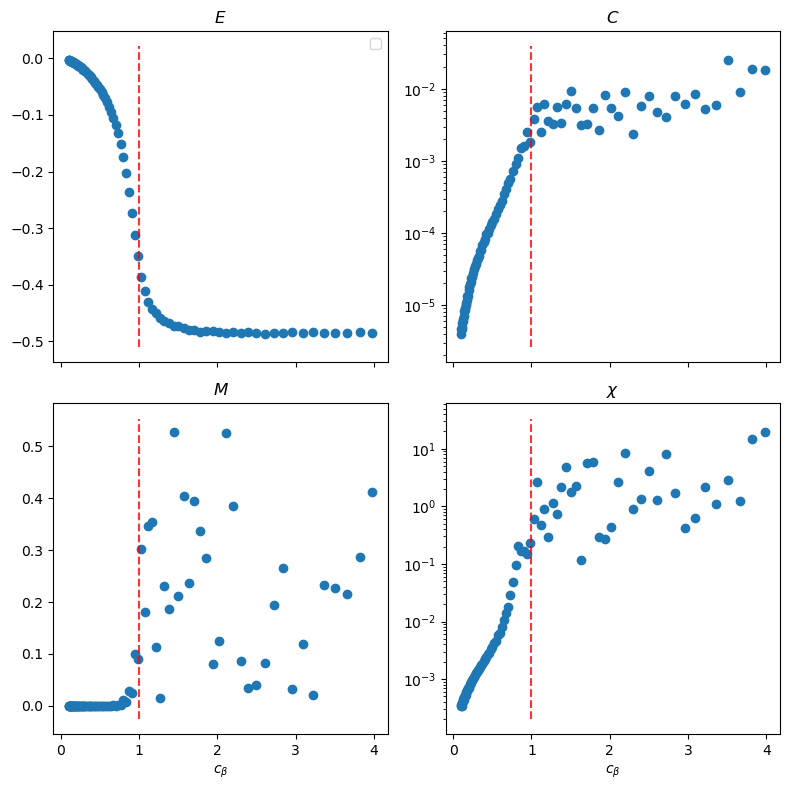

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


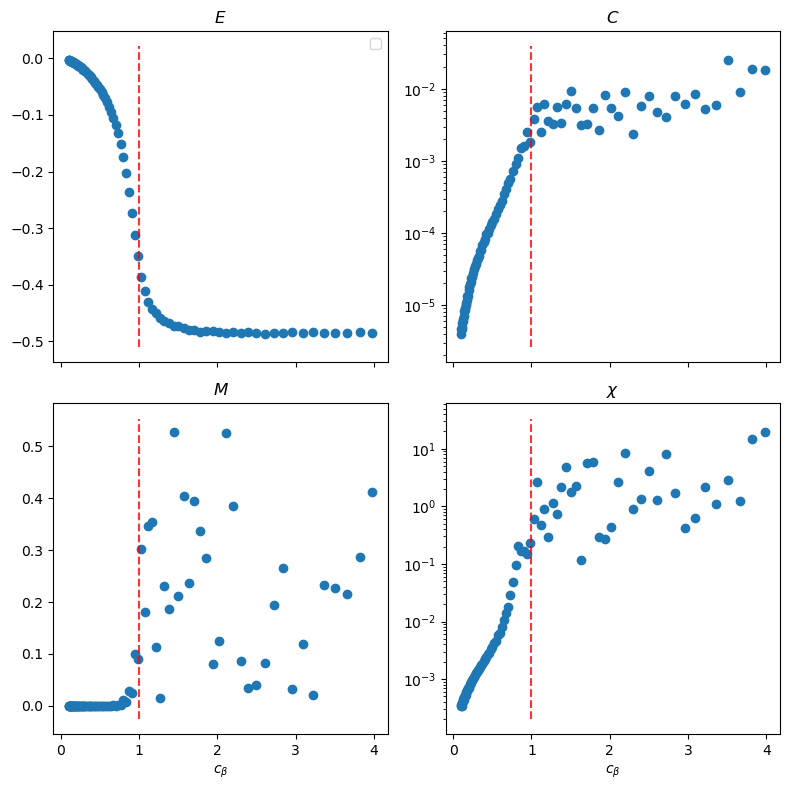

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

E = [obv[0] for obv in all_obvs]
M = [obv[1] for obv in all_obvs]
C = [obv[2] for obv in all_obvs]
X = [obv[3] for obv in all_obvs]

marker = 'o'
axes[0, 0].plot(beta_scales, E, marker)
axes[1, 0].plot(beta_scales, np.abs(M), marker)
axes[0, 1].plot(beta_scales, C, marker)
axes[1, 1].plot(beta_scales, X, marker)


axes[0, 0].set_title(r'$E$')
axes[1, 0].set_title(r'$M$')
axes[0, 1].set_title(r'$C$')
axes[1, 1].set_title(r'$\chi$')

axes[1, 0].set_xlabel(r'$c_{\beta}$')
axes[1, 1].set_xlabel(r'$c_{\beta}$')

axes[0, 1].set_yscale('log')
axes[1, 1].set_yscale('log')

data = [E, C, np.abs(M), X]
for i, ax in enumerate(axes.flatten()):
    ax.vlines(1., ax.get_ylim()[0], ax.get_ylim()[1], 'r', '--', alpha=0.8)
    # ax.set_xscale('log')
axes[0, 0].legend()


# axes[0, 1].set_ylim([0, 1e-3])
# axes[1, 1].set_ylim([0, 1])
plt.tight_layout()
# plt.savefig('ising_stats.png', bbox_inches='tight')